In [1]:
# this website may help you
# https://www.lfd.uci.edu/~gohlke/pythonlibs/
import sys
print(sys.version)
# pip install C:\Users\admin-magstadt\Downloads\GDAL-3.2.3-cp39-cp39-win_amd64.whl

import geopandas as gpd
import ee
from joblib import Parallel, delayed
import os

from pyopensky import OpenskyImpalaWrapper
from osgeo import ogr
from osgeo import osr
import csv

from datetime import datetime
from datetime import datetime, timedelta
import pandas as pd

3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]


C:\Users\admin-magstadt\anaconda3\envs\ee\lib\site-packages\osgeo\ogr.py:22: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


# Path to data

In [ ]:
# full dataset
data = pd.read_csv("C:\\Users\\admin-magstadt\\Desktop\\ADSB_data\\ATUData\\ATU_2017_2021_1mile_ALL.txt", sep=",", header=0)

# data within 500 agl FAA
#data = pd.read_csv("C:\\Users\\admin-magstadt\\Desktop\\ADSB_data\\ATU_2017_2021_ALL_WGS.txt", sep=",", header=0)
#data = pd.read_csv("C:\\Users\\admin-magstadt\\Desktop\\ADSB_data\\ATUData\\ATU_2017_2021_ALL_WGS_500AGL.txt", sep=",", header=0)

#"C:\Users\magst\Desktop\NorCalATUpts\ATU_2017_2021_ALL_WGS_500AGL.txt"

print(list(data.columns))
print("The number of drop samples is... ", len(data))

# DataDownload

##### Define the tail number and return the adsb code

In [ ]:
# Group the data by "Tail_Numbe" and get the unique values
unique_tail_numbers = data.groupby("Tail_Numbe").size().reset_index(name="Count")

# Print the unique tail numbers and their associated count
#print(unique_tail_numbers)

# Define the function to map tail numbers to ADSB codes
def map_tail_number_to_adsb_code(tail_number):
    if tail_number == "T-01":
        return "a5cd6c"
    elif tail_number == "T-02":
        return "a5d123"
    elif tail_number == "T-03":
        return "a5d4da"
    elif tail_number == "T-05":
        return "ad66e3"
    elif tail_number == "T-06":
        return "adc0c4"
    elif tail_number == "T-07":
        return "aafd0b"
    elif tail_number == "T-10":
        return "a5c9b5"
    elif tail_number == "T-101":
        return "a2f996"
    elif tail_number == "T-102":
        return "a2fd4d"
    elif tail_number == "T-103":
        return "a30104"
    elif tail_number == "T-104":
        return "a304bb"
    elif tail_number == "T-105":
        return "a30872"
    elif tail_number == "T-107":
        return "a30fe0"
    elif tail_number == "T-12":
        return "a5d891"
    elif tail_number == "T-131":
        return "a07f21"
    elif tail_number == "T-132":
        return "a4c031"
    elif tail_number == "T-133":
        return "a4b50c"
    elif tail_number == "T-137":
        return "a0956b"
    elif tail_number == "T-14":
        return "a8215e"
    elif tail_number == "T-142":
        return "a19da0"
    elif tail_number == "T-15":
        return "a2b7fd"
    elif tail_number == "T-152":
        return "ac75f9"
    elif tail_number == "T-16":
        return "a5dfff"
    elif tail_number == "T-160":
        return "ab79cc"
    elif tail_number == "T-161":
        return "a3f3ac"
    elif tail_number == "T-162":
        return "a3f763"
    elif tail_number == "T-163":
        return "a42299"
    elif tail_number == "T-164":
        return "a442aa"
    elif tail_number == "T-166":
        return "c07cb2"
    elif tail_number == "T-167":
        return "a85052"
    elif tail_number == "T-168":
        return "a4ea6d"
    elif tail_number == "T-169":
        return "a380e6"
    elif tail_number == "T-210":
        return "a4b460"
    elif tail_number == "T-260":
        return "a47cbc"
    elif tail_number == "T-261":
        return "a48a3a"
    elif tail_number == "T-262":
        return "a47197"
    elif tail_number == "T-263":
        return "a46de0"
    elif tail_number == "T-40":
        return "A9A086"
    elif tail_number == "T-41":
        return "NA"
    elif tail_number == "T-44":
        return "c00e3e"
    elif tail_number == "T-910":
        return "a7f642"
    elif tail_number == "T-911":
        return "a11cbb"
    elif tail_number == "T-912":
        return "a69072"
    elif tail_number == "T-914":
        return "a7d27a"
    elif tail_number == "T-944":
        return "NA"
    elif tail_number == "N130CG":
        return "a07b6a"
    else:    
        return "UNKNOWN_ADSB_CODE"

# Create a new column "adsbCODE" based on the values in the "Tail_Numbe" column
data["adsbCODE"] = data["Tail_Numbe"].apply(lambda x: map_tail_number_to_adsb_code(x))


##### Structure the time of drop 

In [ ]:
data.UTCdateTim = data.UTCdateTim.str[:-4]
#data['UTCdateTim'] = df['UTCdateTim'].str.slice(stop=-9)

# this is nice
#prefixes = ['N130CG', 'N131CG', 'N132CG', 'N137CG', 'N293EA', 'N292EA', 'N294EA', 'N295EA', 'N297EA','N291EA','N138CG']
#data = data[data['Drop_ID1'].str.startswith(tuple(prefixes))]

#data = data[data['Drop_ID1'].str.startswith('N130CG')]
#data = data[data['Drop_ID1'].str.startswith('N130CG')]
#data = data[data['Drop_ID1'].str.startswith('N130CG')]

#print(data.UTCdateTim)
data['UTCdateTim']= pd.to_datetime(data['UTCdateTim'])
#data.UTCdateTime2 = datetime.data.UTCdateTim

time_change = timedelta(minutes=0.25)
data["Time2"] = data.UTCdateTim + time_change
data["Time1"] = data.UTCdateTim - time_change

time_change2 = timedelta(minutes=3.25)
data["Time2_2"] = data.UTCdateTim + time_change2
data["Time1_2"] = data.UTCdateTim - time_change2

# time_change = timedelta(minutes=0.25)
# data["Time2"] = data.UTCdateTim - time_change
# data["Time1"] = data.UTCdateTim - time_change*3

# time_change2 = timedelta(minutes=2.5)
# data["Time2_2"] = data.UTCdateTim - time_change
# data["Time1_2"] = data.UTCdateTim - time_change*3

# data["Latitude1PLUS"] = data.Latitude1+0.02
# data["Latitude1MINUS"] = data.Latitude1-0.02

# data["Longitude1PLUS"] = data.Longitude1+0.02
# data["Longitude1MINUS"] = data.Longitude1-0.02

data["Latitude1PLUS"] = data.Latitude1+0.02
data["Latitude1MINUS"] = data.Latitude1-0.02

data["Longitude1PLUS"] = data.Longitude1+0.02
data["Longitude1MINUS"] = data.Longitude1-0.02

dataLatitude1PLUS =data["Latitude1PLUS"].tolist()
dataLatitude1MINUS =data["Latitude1MINUS"].tolist()

dataLongitude1PLUS =data["Longitude1PLUS"].tolist()
dataLongitude1MINUS =data["Longitude1MINUS"].tolist()

dataLongitude1 =  data.Longitude1.tolist()
dataLatitude1 = data.Latitude1.tolist()

#data.head()
#print(data.columns)
datetime1 = data.Time1.tolist()
datetime2 = data.Time2.tolist()

datetime1_2 = data.Time1_2.tolist()
datetime2_2 = data.Time2_2.tolist()

import pandas as pd
import numpy as np
data=data.replace(regex=[':'], value='_')
data=data.replace(regex=['-'], value='_')
data=data.replace(regex=[' '], value='')

#data
data_DropID = data.Drop_ID1.tolist()
#data_DropID


data["AltMeter1"] = data["AltFeet1"]*0.3048
data_ALT = data["AltMeter1"]+200
data_ALT = data_ALT.tolist()

print("The number of samples is... ",len(data))

##### Download adsb data from opensky

In [ ]:
### Set path to output datasets (they are the same because it doesn't matter)
pathcsv = "C:\\Users\\admin-magstadt\\Desktop\\Data_4_17_2023\\"
pathshp = "C:\\Users\\admin-magstadt\\Desktop\\Data_4_17_2023\\"
pathcsvlongerversion = "C:\\Users\\admin-magstadt\\Desktop\\Data_4_17_2023\\longerversion\\"
pathshplongerversion = "C:\\Users\\admin-magstadt\\Desktop\\Data_4_17_2023\\longerversion\\"

opensky = OpenskyImpalaWrapper()

for i in range(3):#len(data_DropID)):
    print(i)
    # Perform a query with ICAO filter
    df = opensky.query(
        type="adsb",
        #start="2017-06-01 13:00:00",
        #end="2017-07-01 13:00:10",
        #start="2022-06-01",
        #end="2022-08-01",
        start = datetime1[i],
        end = datetime2[i],
        #[lat1, lon1, lat2, lon2]
        #bound=[data.Longitude1MINUS[i],data.Longitude1PLUS[i],data.Latitude1MINUS[i],data.Latitude1PLUS[i]],
        bound=[dataLatitude1MINUS[i],dataLongitude1MINUS[i],dataLatitude1PLUS[i],dataLongitude1PLUS[i]],
        #icao24 = ["a07b6a"]
        icao24 = adsbCODES[i]#IAOC24_CODES#['c00e3e', 'c07cb2', 'a7d27a', 'a69072', 'a11cbb', 'a7f642', 'a9926a', 'ab79cc', 'a3f3ac', 'a3f763', 'a442aa', 'a85052', 'a4ea6d', 'a380e6', 'a4b460', 'a47cbc', 'a48a3a', 'a47197', 'a46de0', 'a4c031', 'a07f21', 'a380e6', 'a4b50c', 'a0956b', 'a2f996', 'a2fd4d', 'a30104', 'a304bb', 'a30872', 'a46de0', 'a47cbc', 'a48a3a', 'a47197', 'a5cd6c', 'a5d123', 'a5d4da', 'ad66e3', 'adc0c4', 'aafd0b', 'a5c9b5', 'a8215e', 'a19da0', 'a2b7fd']
    )
    
    if df is not None:
        #df = df[df["geoaltitude"]<data_ALT[i]]
        #df = df[df['lastposupdate'].nunique() > (len(df)-5)]
        #if (df['lastposupdate'].nunique() > (len(df)-9)) is True and (df['icao24'].nunique() == 1) is True and (len(df) > 25) is True:
        if (df['lastposupdate'].nunique() > (len(df)-15)) is True and (df['icao24'].nunique() == 1) is True and (len(df) > 25) is True:

        #if (df['icao24'].nunique() == 1) is True:

            icaocode24 = df['icao24']
            print("itUniqueEnough")
            df2 = df.dropna(subset = ["lat"])          # Apply dropna() function to remove missing lat lon 
            if len(df2) > 0:
                filepathcsv = pathcsv+data_DropID[i]+".csv"
                df2.to_csv(filepathcsv)
                filepathshp = pathshp+data_DropID[i]+".shp"
                driver = ogr.GetDriverByName("ESRI Shapefile")
                data_src = driver.CreateDataSource(filepathshp)
                srs = osr.SpatialReference()
                srs.ImportFromEPSG(4326)# 4326 = wgs84
                layer = data_src.CreateLayer(filepathshp, 
                                             srs, 
                                             geom_type = ogr.wkbPoint)

                #Create attribute fields from OpenSky
                field_name = ogr.FieldDefn("time", ogr.OFTString)
                field_name.SetWidth(50)
                layer.CreateField(field_name)
                layer.CreateField(ogr.FieldDefn("lon", ogr.OFTReal))
                layer.CreateField(ogr.FieldDefn("lat", ogr.OFTReal))
                layer.CreateField(ogr.FieldDefn("velocity", ogr.OFTReal))
                layer.CreateField(ogr.FieldDefn("heading", ogr.OFTReal))
                layer.CreateField(ogr.FieldDefn("vertrate", ogr.OFTReal))
                layer.CreateField(ogr.FieldDefn("callsign", ogr.OFTString))
                layer.CreateField(ogr.FieldDefn("onground", ogr.OFTString))
                layer.CreateField(ogr.FieldDefn("alert", ogr.OFTString))
                layer.CreateField(ogr.FieldDefn("spi", ogr.OFTString))
                layer.CreateField(ogr.FieldDefn("squawk", ogr.OFTReal))
                layer.CreateField(ogr.FieldDefn("baro", ogr.OFTReal))
                layer.CreateField(ogr.FieldDefn("geo", ogr.OFTReal))
                layer.CreateField(ogr.FieldDefn("lastpos", ogr.OFTReal))
                layer.CreateField(ogr.FieldDefn("lastcon", ogr.OFTReal))
                layer.CreateField(ogr.FieldDefn("hour", ogr.OFTString))
                layer.CreateField(ogr.FieldDefn("icao24", ogr.OFTString))
  
                with open(filepathcsv, "r") as csv_file:
                    csv_reader = csv.reader(csv_file)
                    next(csv_reader)
                    for row in csv_reader:        
                        feature = ogr.Feature(layer.GetLayerDefn())
                        feature.SetField("time", row[1])
                        feature.SetField("lon", row[4])
                        feature.SetField("lat", row[3])
                        feature.SetField("velocity", row[5])
                        feature.SetField("heading", row[6])
                        feature.SetField("vertrate", row[7])
                        feature.SetField("callsign", row[8])
                        feature.SetField("onground", row[9])
                        feature.SetField("alert", row[10])
                        feature.SetField("spi", row[11])
                        feature.SetField("squawk", row[12])
                        feature.SetField("baro", row[13])
                        feature.SetField("geo", row[14])
                        feature.SetField("lastpos", row[15])
                        feature.SetField("lastcon", row[16])
                        feature.SetField("hour", row[17])
                        feature.SetField("icao24", row[2])


                        #Create point geometry
                        point = ogr.Geometry(ogr.wkbPoint)
                        point.AddPoint(float(row[4]), float(row[3]))

                        #Create the feature and set the values 
                        feature.SetGeometry(point)
                        layer.CreateFeature(feature)
                        # reset features for next row
                        feature = None
                data_src = None
            
            ##
            dfLong = opensky.query(
                type="adsb",
                #start="2017-06-01 13:00:00",
                #end="2017-07-01 13:00:10",
                #start="2022-06-01",
                #end="2022-08-01",
                start = datetime1_2[i],
                end = datetime2_2[i],
                #[lat1, lon1, lat2, lon2]
                #bound=[data.Longitude1MINUS[i],data.Longitude1PLUS[i],data.Latitude1MINUS[i],data.Latitude1PLUS[i]],
                #bound=[dataLatitude1MINUS[i],dataLongitude1MINUS[i],dataLatitude1PLUS[i],dataLongitude1PLUS[i]],
                #icao24 = icaocode24
                icao24 = adsbCODES[i]
                )
            
            df2_long = dfLong.dropna(subset = ["lat"])          # Apply dropna() function to remove missing lat lon 
            if len(df2_long) > 0:
                filepathcsvlongerversion = pathcsvlongerversion+data_DropID[i]+".csv"
                df2_long.to_csv(filepathcsv)
                filepathshplongerversion = pathshplongerversion+data_DropID[i]+".shp"
                driver = ogr.GetDriverByName("ESRI Shapefile")
                data_src = driver.CreateDataSource(filepathshp)
                srs = osr.SpatialReference()
                srs.ImportFromEPSG(4326)# 4326 = wgs84
                layer = data_src.CreateLayer(filepathshp, 
                                             srs, 
                                             geom_type = ogr.wkbPoint)

                #Create attribute fields from OpenSky
                field_name = ogr.FieldDefn("time", ogr.OFTString)
                field_name.SetWidth(50)
                layer.CreateField(field_name)
                layer.CreateField(ogr.FieldDefn("lon", ogr.OFTReal))
                layer.CreateField(ogr.FieldDefn("lat", ogr.OFTReal))
                layer.CreateField(ogr.FieldDefn("velocity", ogr.OFTReal))
                layer.CreateField(ogr.FieldDefn("heading", ogr.OFTReal))
                layer.CreateField(ogr.FieldDefn("vertrate", ogr.OFTReal))
                layer.CreateField(ogr.FieldDefn("callsign", ogr.OFTString))
                layer.CreateField(ogr.FieldDefn("onground", ogr.OFTString))
                layer.CreateField(ogr.FieldDefn("alert", ogr.OFTString))
                layer.CreateField(ogr.FieldDefn("spi", ogr.OFTString))
                layer.CreateField(ogr.FieldDefn("squawk", ogr.OFTReal))
                layer.CreateField(ogr.FieldDefn("baro", ogr.OFTReal))
                layer.CreateField(ogr.FieldDefn("geo", ogr.OFTReal))
                layer.CreateField(ogr.FieldDefn("lastpos", ogr.OFTReal))
                layer.CreateField(ogr.FieldDefn("lastcon", ogr.OFTReal))
                layer.CreateField(ogr.FieldDefn("hour", ogr.OFTString))
                layer.CreateField(ogr.FieldDefn("icao24", ogr.OFTString))

    
                with open(filepathcsvlongerversion, "r") as csv_file:
                    csv_reader = csv.reader(csv_file)
                    next(csv_reader)
                    for row in csv_reader:        
                        feature = ogr.Feature(layer.GetLayerDefn())
                        feature.SetField("time", row[1])
                        feature.SetField("lon", row[4])
                        feature.SetField("lat", row[3])
                        feature.SetField("velocity", row[5])
                        feature.SetField("heading", row[6])
                        feature.SetField("vertrate", row[7])
                        feature.SetField("callsign", row[8])
                        feature.SetField("onground", row[9])
                        feature.SetField("alert", row[10])
                        feature.SetField("spi", row[11])
                        feature.SetField("squawk", row[12])
                        feature.SetField("baro", row[13])
                        feature.SetField("geo", row[14])
                        feature.SetField("lastpos", row[15])
                        feature.SetField("lastcon", row[16])
                        feature.SetField("hour", row[17])
                        feature.SetField("icao24", row[2])


                        #Create point geometry
                        point = ogr.Geometry(ogr.wkbPoint)
                        point.AddPoint(float(row[4]), float(row[3]))

                        #Create the feature and set the values 
                        feature.SetGeometry(point)
                        layer.CreateFeature(feature)
                        # reset features for next row
                        feature = None
                data_src = None
            ####

# Data Processing in GEE

##### Short version of drops

In [1]:
import os

ee.Authenticate()
ee.Initialize(project = 'ee-magstadt')
#input_folder = pathshp
input_folder = "C:\\Users\\admin-magstadt\\Desktop\\Data_4_17_2023\\"

output_folder_short = "C:\\Users\\admin-magstadt\\Desktop\\Data_4_17_2023\\outputdataDROP\\"

# Loop over all shapefiles in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".shp"):
        print("Processing:", filename)
        # Construct input and output file paths
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder_short, filename[:-4] + ".csv")  # Remove ".shp" from input filename and add ".csv"
        
        # Run the existing script with the input and output file paths
        import ee
        import geemap
        import pandas as pd
        import time

        try:
            start_time = time.time()

            ee_fc = geemap.shp_to_ee(input_path)

            # Load the 3DEP dataset  and others and filter by the extent of the points
            dem = ee.Image("USGS/3DEP/10m").clip(ee_fc.geometry().bounds())

            # Extract data for each image at appropriate scale
            terrain_fc = ee.Terrain.products(dem).sampleRegions(collection=ee_fc, scale=10.2)

            # Convert the elevation and terrain product data to Pandas DataFrames
            terrain_df = geemap.ee_to_pandas(terrain_fc)

            # Drop rows with missing values
            df_sample = terrain_df.dropna()

            # Calculate height AGL
            baro_altitude = df_sample['geo']
            elevation = df_sample['elevation']
            height_AGL = baro_altitude - elevation
            df_sample['heightAGL'] = height_AGL

            # Export as CSV
            df_sample.to_csv(output_path, index=False)

            print("Completed:", filename)
        except Exception as e:
            print("Error occurred:", e)
            continue


NameError: name 'ee' is not defined

##### Longer version of drops

In [ ]:
ee.Initialize(project = 'ee-magstadt')

#input_folder = pathshplongerversion
input_folder = "C:\\Users\\admin-magstadt\\Desktop\\Data_4_17_2023\\longerversion\\"

output_folder_long = "C:\\Users\\admin-magstadt\\Desktop\\Data_4_17_2023\\outputdataDROPLONG\\"

# Loop over all shapefiles in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".shp"):
        print("Processing:", filename)
        # Construct input and output file paths
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder_long, filename[:-4] + ".csv")  # Remove ".shp" from input filename and add ".csv"
        
        # Run the existing script with the input and output file paths
        import ee
        import geemap
        import pandas as pd
        import time

        try:
            start_time = time.time()

            ee_fc = geemap.shp_to_ee(input_path)

            # Load the 3DEP dataset  and others and filter by the extent of the points
            dem = ee.Image("USGS/3DEP/10m").clip(ee_fc.geometry().bounds())

            # Extract data for each image at appropriate scale
            terrain_fc = ee.Terrain.products(dem).sampleRegions(collection=ee_fc, scale=10.2)

            # Convert the elevation and terrain product data to Pandas DataFrames
            terrain_df = geemap.ee_to_pandas(terrain_fc)

            # Drop rows with missing values
            df_sample = terrain_df.dropna()

            # Calculate height AGL
            baro_altitude = df_sample['geo']
            elevation = df_sample['elevation']
            height_AGL = baro_altitude - elevation
            df_sample['heightAGL'] = height_AGL

            # Export as CSV
            df_sample.to_csv(output_path, index=False)

            print("Completed:", filename)
        except Exception as e:
            print("Error occurred:", e)
            continue


# 1D CNN Modeling

##### Setting Up ATU drop data 

In [41]:
import pandas as pd
import numpy as np
import glob

#dir_path = output_folder_short
dir_path = "C:\\Users\\admin-magstadt\\Desktop\\Data_4_17_2023\\outputdataDROP\\"
#dir_path = "C:\\Users\\admin-magstadt\\Desktop\\Data_4_3_2023\\"

filenames = glob.glob(dir_path + "*.csv")

data = []

for filename in filenames:
    num_rows = sum(1 for line in open(filename))
    if num_rows < 26:
        #print(f"Skipping {filename}: less than 25 rows")
        continue
    df = pd.read_csv(filename, usecols=[4,8,21], nrows=25, skiprows=num_rows-26)
    arr = df.values.astype(float)
    data.append(arr)

if len(data) == 0:
    print("No data found")
else:
    array1 = np.stack(data, axis=0)
    print(array1.shape)


(937, 25, 3)


In [ ]:
# import matplotlib.pyplot as plt

# # Select the first 100 samples' velocity data
# velocity_data = array1[:80, :, 2]

# # Create a figure and axes for the plot
# fig, ax = plt.subplots()

# # Iterate through the first 100 samples and plot their velocity data
# for i, sample_velocity in enumerate(velocity_data):
#     ax.plot(sample_velocity)#, label=f'Sample {i + 1}')

# # Add labels and legend (optional)
# ax.set_xlabel('Time Steps')
# ax.set_ylabel('Velocity')
# #ax.legend(loc='upper left', ncol=2, fontsize='small')#, title='Samples')#, bbox_to_anchor=(1.05, 1)

# # Show the plot
# plt.show()


In [ ]:
# import matplotlib.pyplot as plt

# # Select a sample from the dataset
# sample_index = 200  # Choose any index between 0 and len(data) - 1
# sample_data = array1[sample_index]

# # Separate the columns (variables) in the sample_data
# variable_1 = sample_data[:, 0]
# variable_2 = sample_data[:, 1]
# variable_3 = sample_data[:, 2]

# # Create the line plots
# #plt.plot(variable_1, label='Velocity (m/s)')
# #plt.plot(variable_2, label='Vertical climbing rate (m/s)')
# plt.plot(variable_3, label='Height AGL')

# # Add labels and legend
# plt.xlabel('Time Steps')
# plt.ylabel('Variable Values')
# plt.legend()

# # Show the plot
# plt.show()


In [ ]:
# import pandas as pd
# import numpy as np
# import glob

# dir_path = "C:\\Users\\admin-magstadt\\Desktop\\Data_4_17_2023\\outputdataDROP\\"

# filenames = glob.glob(dir_path + "*.csv")

# data = []

# for filename in filenames:
#     df = pd.read_csv(filename, usecols=[4, 8, 21], nrows=25)
#     if df.shape[0] < 25:
#         #print(f"Skipping {filename}: less than 25 rows")
#         continue
#     arr = df.values.astype(float)
#     data.append(arr)

# if len(data) == 0:
#     print("No data found")
# else:
#     array1 = np.stack(data, axis=0)
#     print(array1.shape)


##### Setting Up Non-ATU drop data 

In [42]:
import pandas as pd
import numpy as np
import glob

dir_path = "C:\\Users\\admin-magstadt\\Desktop\\Data_4_17_2023\\outputdataDROPLONG\\"
filenames = glob.glob(dir_path + "*.csv")

data = []

for filename in filenames:
    num_rows = sum(1 for line in open(filename))
    if num_rows < 51:
        #print(f"Skipping {filename}: less than 51 rows")
        continue
    df = pd.read_csv(filename, usecols=[4, 8, 21], nrows=25)#, skiprows=range(1, 50))
    arr = df.values.astype(float)
    data.append(arr)

if len(data) == 0:
    print("No data found")
else:
    array2 = np.stack(data, axis=0)
    print(array2.shape)


(1170, 25, 3)


In [43]:
import pandas as pd
import numpy as np
import glob

dir_path = "C:\\Users\\admin-magstadt\\Desktop\\Data_4_17_2023\\outputdataDROPLONG\\"
filenames = glob.glob(dir_path + "*.csv")

data = []

for filename in filenames:
    num_rows = sum(1 for line in open(filename))
    if num_rows < 51:
        #print(f"Skipping {filename}: less than 51 rows")
        continue
    df = pd.read_csv(filename, usecols=[4, 8, 21], nrows=25, skiprows=range(0, 26))
    arr = df.values.astype(float)
    data.append(arr)

if len(data) == 0:
    print("No data found")
else:
    array3 = np.stack(data, axis=0)
    print(array3.shape)


(1170, 25, 3)


In [44]:
import pandas as pd
import numpy as np
import glob

dir_path = "C:\\Users\\admin-magstadt\\Desktop\\Data_4_17_2023\\outputdataDROPLONG\\"
filenames = glob.glob(dir_path + "*.csv")

data = []

for filename in filenames:
    num_rows = sum(1 for line in open(filename))
    if num_rows < 51:
        #print(f"Skipping {filename}: less than 51 rows")
        continue
    df = pd.read_csv(filename, usecols=[4, 8, 21], nrows=25, skiprows=range(0, 51))
    arr = df.values.astype(float)
    data.append(arr)

if len(data) == 0:
    print("No data found")
else:
    array4 = np.stack(data, axis=0)
    print(array4.shape)


(1170, 25, 3)


In [45]:
import pandas as pd
import numpy as np
import glob

dir_path = "C:\\Users\\admin-magstadt\\Desktop\\Data_4_17_2023\\outputdataDROPLONG\\"
filenames = glob.glob(dir_path + "*.csv")

data = []

for filename in filenames:
    num_rows = sum(1 for line in open(filename))
    if num_rows < 51:
        #print(f"Skipping {filename}: less than 51 rows")
        continue
    df = pd.read_csv(filename, usecols=[4, 8, 21], nrows=25, skiprows=range(0, 75))
    arr = df.values.astype(float)
    data.append(arr)

if len(data) == 0:
    print("No data found")
else:
    array5 = np.stack(data, axis=0)
    print(array5.shape)


(1170, 25, 3)


In [46]:
import pandas as pd
import numpy as np
import glob

dir_path = "C:\\Users\\admin-magstadt\\Desktop\\Data_4_17_2023\\outputdataDROPLONG\\"
filenames = glob.glob(dir_path + "*.csv")

data = []

for filename in filenames:
    num_rows = sum(1 for line in open(filename))
    if num_rows < 51:
        #print(f"Skipping {filename}: less than 51 rows")
        continue
    df = pd.read_csv(filename, usecols=[4, 8, 21], nrows=25, skiprows=range(0, 100))
    arr = df.values.astype(float)
    data.append(arr)

if len(data) == 0:
    print("No data found")
else:
    array6 = np.stack(data, axis=0)
    print(array6.shape)


(1170, 25, 3)


In [47]:
#Backend
import pandas as pd
import numpy as np
import glob

dir_path = "C:\\Users\\admin-magstadt\\Desktop\\Data_4_17_2023\\outputdataDROPLONG\\"
filenames = glob.glob(dir_path + "*.csv")

data = []

for filename in filenames:
    num_rows = sum(1 for line in open(filename))
    if num_rows < 51:
        #print(f"Skipping {filename}: less than 51 rows")
        continue
    df = pd.read_csv(filename, usecols=[4, 8, 21])
    df = df.iloc[-50:-25]
    arr = df.values.astype(float)
    data.append(arr)

if len(data) == 0:
    print("No data found")
else:
    array7 = np.stack(data, axis=0)
    print(array7.shape)

(1170, 25, 3)


In [48]:
#Backend
import pandas as pd
import numpy as np
import glob

dir_path = "C:\\Users\\admin-magstadt\\Desktop\\Data_4_17_2023\\outputdataDROPLONG\\"
filenames = glob.glob(dir_path + "*.csv")

data = []

for filename in filenames:
    num_rows = sum(1 for line in open(filename))
    if num_rows < 51:
        #print(f"Skipping {filename}: less than 51 rows")
        continue
    df = pd.read_csv(filename, usecols=[4, 8, 21])
    df = df.iloc[-75:-50]
    arr = df.values.astype(float)
    data.append(arr)

if len(data) == 0:
    print("No data found")
else:
    array8 = np.stack(data, axis=0)
    print(array8.shape)

(1170, 25, 3)


In [49]:
#Backend
import pandas as pd
import numpy as np
import glob

dir_path = "C:\\Users\\admin-magstadt\\Desktop\\Data_4_17_2023\\outputdataDROPLONG\\"
filenames = glob.glob(dir_path + "*.csv")

data = []

for filename in filenames:
    num_rows = sum(1 for line in open(filename))
    if num_rows < 51:
        #print(f"Skipping {filename}: less than 51 rows")
        continue
    df = pd.read_csv(filename, usecols=[4, 8, 21])
    df = df.iloc[-100:-75]
    arr = df.values.astype(float)
    data.append(arr)

if len(data) == 0:
    print("No data found")
else:
    array9 = np.stack(data, axis=0)
    print(array9.shape)

(1170, 25, 3)


In [50]:
#Backend
import pandas as pd
import numpy as np
import glob

dir_path = "C:\\Users\\admin-magstadt\\Desktop\\Data_4_17_2023\\outputdataDROPLONG\\"
filenames = glob.glob(dir_path + "*.csv")

data = []

for filename in filenames:
    num_rows = sum(1 for line in open(filename))
    if num_rows < 51:
        #print(f"Skipping {filename}: less than 51 rows")
        continue
    df = pd.read_csv(filename, usecols=[4, 8, 21])
    df = df.iloc[-125:-100]
    arr = df.values.astype(float)
    data.append(arr)

if len(data) == 0:
    print("No data found")
else:
    array10 = np.stack(data, axis=0)
    print(array10.shape)

(1170, 25, 3)


In [51]:
stacked_array = np.concatenate((array2,array3,array4,array5,array6,array7,array8,array9,array10), axis=0)
print(stacked_array.shape)

combined_array = np.concatenate((array1, stacked_array), axis=0)
print(combined_array.shape)

(10530, 25, 3)
(11467, 25, 3)


### Label arrays (one-drop, zero-nondrop)

In [52]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation,
DROP_label = np.concatenate((np.ones(array1.shape[0]), np.zeros(stacked_array.shape[0])))

train_data, test_data, train_labels, test_labels = train_test_split(combined_array, DROP_label, test_size=0.3, random_state=545)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.3, random_state=545)


# RNN LSTM

In [54]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape))
    #model.add(Dropout(0.5))
    #model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (train_data.shape[1], train_data.shape[2])
modelRNN = create_lstm_model(input_shape)

history = modelRNN.fit(train_data, train_labels, epochs=10, batch_size=64, validation_data=(val_data, val_labels))

test_loss, test_acc = modelRNN.evaluate(test_data, test_labels)
print('Test accuracy:', test_acc)


Epoch 1/10
88/88 [==============================] - 5s 32ms/step - loss: 0.4029 - accuracy: 0.8594 - val_loss: 0.1930 - val_accuracy: 0.9402
Epoch 2/10
88/88 [==============================] - 2s 20ms/step - loss: 0.1830 - accuracy: 0.9386 - val_loss: 0.1398 - val_accuracy: 0.9502
Epoch 3/10
88/88 [==============================] - 2s 19ms/step - loss: 0.1599 - accuracy: 0.9434 - val_loss: 0.1288 - val_accuracy: 0.9518
Epoch 4/10
88/88 [==============================] - 2s 19ms/step - loss: 0.1482 - accuracy: 0.9473 - val_loss: 0.1266 - val_accuracy: 0.9502
Epoch 5/10
88/88 [==============================] - 2s 20ms/step - loss: 0.1402 - accuracy: 0.9512 - val_loss: 0.1278 - val_accuracy: 0.9522
Epoch 6/10
88/88 [==============================] - 2s 20ms/step - loss: 0.1381 - accuracy: 0.9477 - val_loss: 0.1179 - val_accuracy: 0.9581
Epoch 7/10
88/88 [==============================] - 2s 18ms/step - loss: 0.1415 - accuracy: 0.9489 - val_loss: 0.1281 - val_accuracy: 0.9481
Epoch 8/10
88

In [36]:
from kerastuner import HyperModel, Hyperband

class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(LSTM(hp.Int('units', min_value=32, max_value=128, step=32), input_shape=self.input_shape))
        model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.6, step=0.1)))
        model.add(Dense(hp.Int('dense_units', min_value=16, max_value=64, step=16), activation='relu'))
        model.add(Dropout(hp.Float('dense_dropout', min_value=0.2, max_value=0.6, step=0.1)))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model


In [37]:
hypermodel = LSTMHyperModel(input_shape)


In [38]:
tuner = Hyperband(hypermodel, objective='val_accuracy', max_epochs=10, factor=3)


In [39]:
tuner.search(train_data, train_labels, epochs=10, batch_size=64, validation_data=(val_data, val_labels))


Trial 30 Complete [00h 00m 18s]
val_accuracy: 0.9555647969245911

Best val_accuracy So Far: 0.9634551405906677
Total elapsed time: 00h 08m 05s
INFO:tensorflow:Oracle triggered exit


In [40]:
best_model = tuner.get_best_models(num_models=1)[0]

test_loss, test_acc = best_model.evaluate(test_data, test_labels)
print('Test accuracy:', test_acc)


108/108 [==============================] - 2s 10ms/step - loss: 0.1200 - accuracy: 0.9587
Test accuracy: 0.9587329030036926


# 1dcnn

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout


def create_1dcnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(25, 3)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (train_data.shape[1], train_data.shape[2])
modelCNN = create_1dcnn_model(input_shape)

history = modelCNN.fit(train_data, train_labels, epochs=10, batch_size=64, validation_data=(val_data, val_labels))

test_loss, test_acc = modelCNN.evaluate(test_data, test_labels)
print('Test accuracy:', test_acc)


Epoch 1/10
88/88 [==============================] - 2s 9ms/step - loss: 5.0070 - accuracy: 0.9078 - val_loss: 1.3926 - val_accuracy: 0.9535
Epoch 2/10
88/88 [==============================] - 1s 6ms/step - loss: 1.0635 - accuracy: 0.9356 - val_loss: 0.6564 - val_accuracy: 0.9502
Epoch 3/10
88/88 [==============================] - 1s 6ms/step - loss: 0.3844 - accuracy: 0.9368 - val_loss: 0.3980 - val_accuracy: 0.9489
Epoch 4/10
88/88 [==============================] - 1s 6ms/step - loss: 0.3106 - accuracy: 0.9432 - val_loss: 0.4456 - val_accuracy: 0.9547
Epoch 5/10
88/88 [==============================] - 0s 5ms/step - loss: 0.2045 - accuracy: 0.9487 - val_loss: 0.4724 - val_accuracy: 0.9568
Epoch 6/10
88/88 [==============================] - 1s 6ms/step - loss: 0.1876 - accuracy: 0.9491 - val_loss: 0.4103 - val_accuracy: 0.9514
Epoch 7/10
88/88 [==============================] - 0s 6ms/step - loss: 0.1745 - accuracy: 0.9486 - val_loss: 0.3747 - val_accuracy: 0.9547
Epoch 8/10
88/88 [==

In [ ]:
# from keras.models import Sequential
# from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# # Define CNN architecture
# model = Sequential()
# model.add(Conv1D(filters=8, kernel_size=5, activation='relu', input_shape=(25, 3)))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(filters=8, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=25, batch_size=4)

# # Evaluate the model on test set
# test_loss, test_acc = model.evaluate(test_data, test_labels)
# print('Test accuracy:', test_acc)

In [55]:
from sklearn.metrics import confusion_matrix

# Assuming you have the necessary data and the model trained

# Make predictions on the test data
test_predictions = modelRNN.predict(test_data)
test_predictions = np.round(test_predictions).flatten()

# Create the confusion matrix
confusion = confusion_matrix(test_labels, test_predictions)

print("Confusion Matrix:")
print(confusion)


108/108 [==============================] - 1s 8ms/step
Confusion Matrix:
[[3093   60]
 [  97  191]]


108/108 [==============================] - 0s 2ms/step


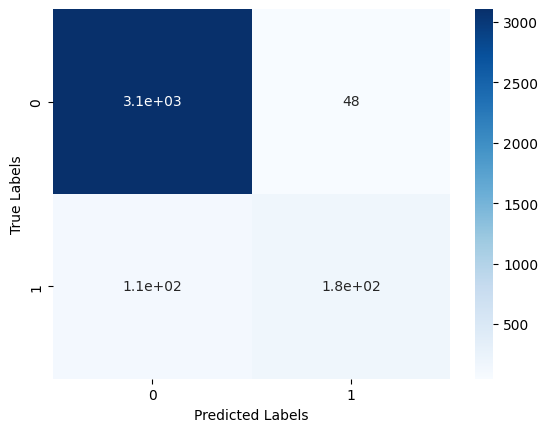

In [56]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get the predicted labels for the test set
y_pred = modelCNN.predict(test_data)
y_pred = (y_pred > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


### DOWNLOAD FROM OPENSKY AND PREDICT

In [ ]:
import datetime
import geemap
import ee

# Initialize the Earth Engine library
ee.Initialize(project = 'ee-magstadt')

from pyopensky import OpenskyImpalaWrapper
opensky = OpenskyImpalaWrapper()


timestamp = 1600454324
converted_time1 = datetime.datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')

timestamp2 = 1600454324+30
converted_time2 = datetime.datetime.utcfromtimestamp(timestamp2).strftime('%Y-%m-%d %H:%M:%S')

# Get the current time
start_time = datetime.datetime.now()

df = opensky.query(
        type="adsb",
        #start="2017-06-01 13:00:00",
        #end="2017-07-01 13:00:10",
        #start="2020-09-18 18:38:44",
        #end="2020-09-18 18:38:54",
        start = str(converted_time1),#datetime.datetime.fromtimestamp(timestamp),
        end = str(converted_time2),
        
        #[lat1, lon1, lat2, lon2]
        #bound=[data.Longitude1MINUS[i],data.Longitude1PLUS[i],data.Latitude1MINUS[i],data.Latitude1PLUS[i]],
        #bound=[dataLatitude1MINUS[i],dataLongitude1MINUS[i],dataLatitude1PLUS[i],dataLongitude1PLUS[i]],
        #icao24 = ["a07b6a"]
        icao24 = ['a30fe0']#adsbCODES[i]#IAOC24_CODES#['c00e3e', 'c07cb2', 'a7d27a', 'a69072', 'a11cbb', 'a7f642', 'a9926a', 'ab79cc', 'a3f3ac', 'a3f763', 'a442aa', 'a85052', 'a4ea6d', 'a380e6', 'a4b460', 'a47cbc', 'a48a3a', 'a47197', 'a46de0', 'a4c031', 'a07f21', 'a380e6', 'a4b50c', 'a0956b', 'a2f996', 'a2fd4d', 'a30104', 'a304bb', 'a30872', 'a46de0', 'a47cbc', 'a48a3a', 'a47197', 'a5cd6c', 'a5d123', 'a5d4da', 'ad66e3', 'adc0c4', 'aafd0b', 'a5c9b5', 'a8215e', 'a19da0', 'a2b7fd']
    )

ee_df = geemap.pandas_to_ee(df, latitude = 'lat', longitude='lon')
# Create a Map and add the Earth Engine object as points
Map = geemap.Map()#center=[38.45, -122.59], zoom=12)
Map.addLayer(ee_df, {'color': 'red'}, 'Aircraft Points')

# Display the map
Map

# Load the 3DEP dataset  and others and filter by the extent of the points
dem = ee.Image("USGS/3DEP/10m").clip(ee_df.geometry().bounds())

# Extract data for each image at appropriate scale
terrain_fc = ee.Terrain.products(dem).sampleRegions(collection=ee_df, scale=10.2)

# Convert the elevation and terrain product data to Pandas DataFrames
terrain_df = geemap.ee_to_pandas(terrain_fc)

# Drop rows with missing values
df_sample = terrain_df.dropna()

# Calculate height AGL
baro_altitude = df_sample['geoaltitude']
elevation = df_sample['elevation']
height_AGL = baro_altitude - elevation
df_sample['heightAGL'] = height_AGL

# Get the current time again
end_time = datetime.datetime.now()

# Calculate the time difference
time_difference = end_time - start_time

# Print the time difference
print("Time difference:", time_difference)

In [ ]:
# prep data for pred
subset_array = df_sample[['velocity', 'vertrate', 'heightAGL']].values[:25]
subset_array.shape

# shape it correctly for the model.predict
arrayPRED = np.reshape(subset_array, (1, 25, 3))
#arrayPRED.shape

# Make predictions
prediction = model.predict(arrayPRED)

In [ ]:
# for prediction output shp
df_sample_PRED = df_sample[['lat', 'lon']].iloc[14:15].copy()
df_sample_PRED['prediction'] = prediction
df_sample_PRED

In [ ]:

filepathshpATU = 'C:\\Users\\admin-magstadt\\Desktop\\OutputSHP\\point_shapefile8.shp'

# Configure the OGR driver and data source
driver = ogr.GetDriverByName("ESRI Shapefile")
data_src = driver.CreateDataSource(filepathshpATU)

# Set the spatial reference system (EPSG:4326 for WGS84)
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)

# Create the layer in the data source
layer = data_src.CreateLayer(filepathshpATU, srs, ogr.wkbPoint)

# Define the attribute fields for the layer
field_def = ogr.FieldDefn("prediction", ogr.OFTReal)
layer.CreateField(field_def)

# Iterate over the DataFrame rows and add points to the layer
for index, row in df_sample_PRED.iterrows():
    point = ogr.Geometry(ogr.wkbPoint)
    point.AddPoint(row['lon'], row['lat'])
    
    feature = ogr.Feature(layer.GetLayerDefn())
    feature.SetGeometry(point)
    feature.SetField("prediction", float(row['prediction']))
    
    layer.CreateFeature(feature)

# Save and close the data source
data_src.SyncToDisk()
data_src = None


In [ ]:
# import matplotlib.pyplot as plt

# # Select the first 100 samples' velocity data
# velocity_data = array2[:80, :, 2]

# # Create a figure and axes for the plot
# fig, ax = plt.subplots()

# # Iterate through the first 100 samples and plot their velocity data
# for i, sample_velocity in enumerate(velocity_data):
#     ax.plot(sample_velocity)#, label=f'Sample {i + 1}')

# # Add labels and legend (optional)
# ax.set_xlabel('Time Steps')
# ax.set_ylabel('Velocity')
# #ax.legend(loc='upper left', ncol=2, fontsize='small')#, title='Samples')#, bbox_to_anchor=(1.05, 1)

# # Show the plot
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# # Select a sample from the dataset
# sample_index = 120  # Choose any index between 0 and len(data) - 1
# sample_data = array2[sample_index]

# # Separate the columns (variables) in the sample_data
# variable_1 = sample_data[:, 0]
# variable_2 = sample_data[:, 1]
# variable_3 = sample_data[:, 2]

# # Create the line plots
# plt.plot(variable_1, label='Velocity (m/s)')
# plt.plot(variable_2, label='Vertical climbing rate (m/s)')
# plt.plot(variable_3, label='Height AGL')

# # Add labels and legend
# plt.xlabel('Time Steps')
# plt.ylabel('Variable Values')
# plt.legend()

# # Show the plot
# plt.show()
